In [2]:
!mkdir results
!ls
!ls results

mkdir: `results' 디렉토리를 만들 수 없습니다: 파일이 있습니다
 Lab6_result_report.ipynb  'json&hash.ipynb'   results	 test.json


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

# Data Preparation

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model Architecture

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

# Train, Validate, Test and Experiment

In [7]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [8]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [9]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [10]:
def experiment(partition, args):
  
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    #vars(args)는 딕셔너리가 됨, result는 딕셔너리
    return vars(args), result
    # ===================================== #


# Manage Experiment Result

In [11]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    #같은 세팅이어도 epoch이 바뀌면 파일이 따로 생김 => epoch이 바뀌어도 다른 파일이 생기지 않도록 지워줌
    del setting['epoch']
    #test_batch_size는 실험에 영향을 주는 값이 아니기 때문에 지워줌
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    #update => 딕셔너리와 딕셔너리를 합침 result + setting
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df
    

# Experiment

In [12]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        #setattr(args, name_var1, var1) => args.name_var1 = var1 (같은 문법)
        #name_var1이 string임 => 임의의 attribute에 대해서 string으로 attribute name이 주어지면 그 항목 값을 var1 값으로 세팅
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp1_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=500, act='relu', dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='RMSprop', lr=0.0015, epoch=10, train_batch_size=256, test_batch_size=1024, n_layer=1)
Epoch 0, Acc(train/val): 38.08/35.17, Loss(train/val) 2.53/2.30. Took 1.58 sec
Epoch 1, Acc(train/val): 46.10/37.08, Loss(train/val) 1.57/2.01. Took 1.56 sec
Epoch 2, Acc(train/val): 49.38/39.92, Loss(train/val) 1.48/1.85. Took 1.57 sec
Epoch 3, Acc(train/val): 50.69/45.27, Loss(train/val) 1.45/1.61. Took 1.58 sec
Epoch 4, Acc(train/val): 53.10/44.91, Loss(train/val) 1.38/1.69. Took 1.56 sec
Epoch 5, Acc(train/val): 55.35/46.44, Loss(train/val) 1.31/1.65. Took 1.54 sec
Epoch 6, Acc(train/val): 56.27/45.35, Loss(train/val) 1.29/1.76. Took 1.56 sec
Epoch 7, Acc(train/val): 58.66/41.38, Loss(train/val) 1.22/2.07. Took 1.66 sec
Epoch 8, Acc(train/val): 59.78/42.68, Loss(train/val) 1.21/1.91. Took 1.65 sec
Epoch 9, Acc(train/val): 61.66/46.25, Loss(train/v

In [19]:
!ls results
!cat results/exp1_n_layer_hid_dim-41b634.json

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json
{"train_losses": [1.780252301768892, 1.5172213885434873, 1.4081822405954836, 1.3340516006870635, 1.2620286485951417, 1.2023386469312534, 1.1592101982444714, 1.0969501342743067, 1.0540159823028905, 0.9985612327126181], "val_losses": [1.709606146812439, 1.6802670359611511, 1.518134343624115, 1.4921130657196044, 1.4634076952934265, 1.5621140360832215, 1.5573631286621095, 1.438623344898224, 1.6080994009971619, 1.4584532856941224], "train_accs": [36.66, 45.6225, 49.595, 52.4575, 54.8925, 56.74, 58.4875, 60.735, 62.095, 64.1825], "val_accs": [39.19, 40.23, 45.85, 47.0, 49.09, 45.0, 46.96, 50.75, 47.42, 51.11], "train_acc": 64.1825, "val_acc": 51.11, "test_acc": 51.48, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true

# 시각화하기

# Pandas & seaborn

<class 'pandas.core.frame.DataFrame'>
   age gender  score  t
0    5      f     10  1
1    6      m      9  1
2    7      f      1  1
3   15      f      2  2
4   16      m      5  2
5   25      f      7  2
6   26      m      3  2


<AxesSubplot:xlabel='age', ylabel='score'>

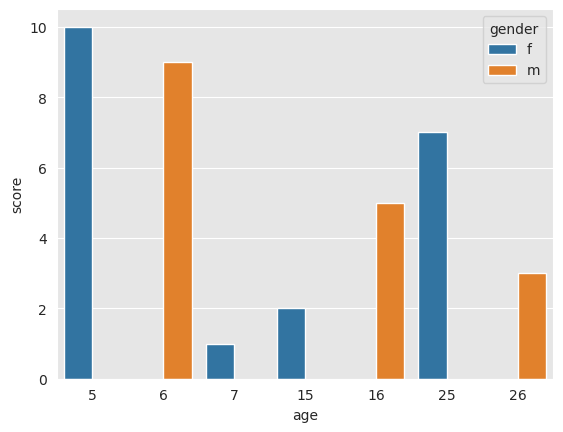

In [36]:
print(type(load_exp_result('exp1')))

# pandas => excel의 python 버전

a = [{'age':5, 'gender':'f', 'score':10, 't':1}, {'age':6, 'gender':'m', 'score':9, 't':1}, {'age':7, 'gender':'f', 'score':1, 't':1},
    {'age':15, 'gender':'f', 'score':2, 't':2}, {'age':16, 'gender':'m', 'score':5, 't':2},{'age':25, 'gender':'f', 'score':7, 't':2}, {'age':26, 'gender':'m', 'score':3, 't':2}]
df = pd.DataFrame(a)
print(df)

#age와 gender에 따른 score의 변화보기

import seaborn as sns

#hue : 범례 (색깔)
sns.barplot(x='age', y='score', hue='gender', data=df)

<AxesSubplot:xlabel='n_layer', ylabel='test_acc'>

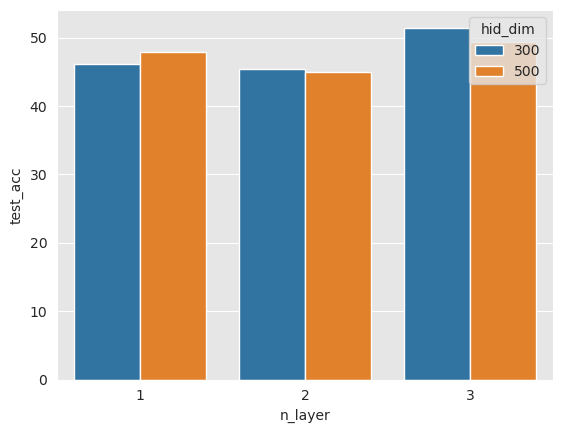

In [38]:
result = load_exp_result('exp1')

sns.barplot(x='n_layer', y = 'test_acc', hue= 'hid_dim', data=result)

<AxesSubplot:xlabel='n_layer', ylabel='test_acc'>

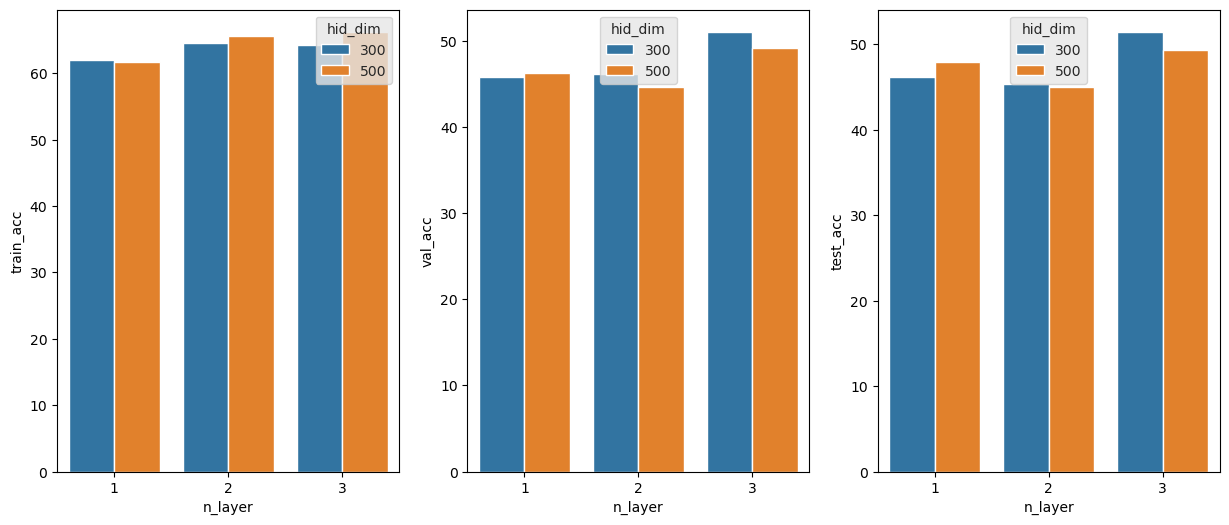

In [13]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])


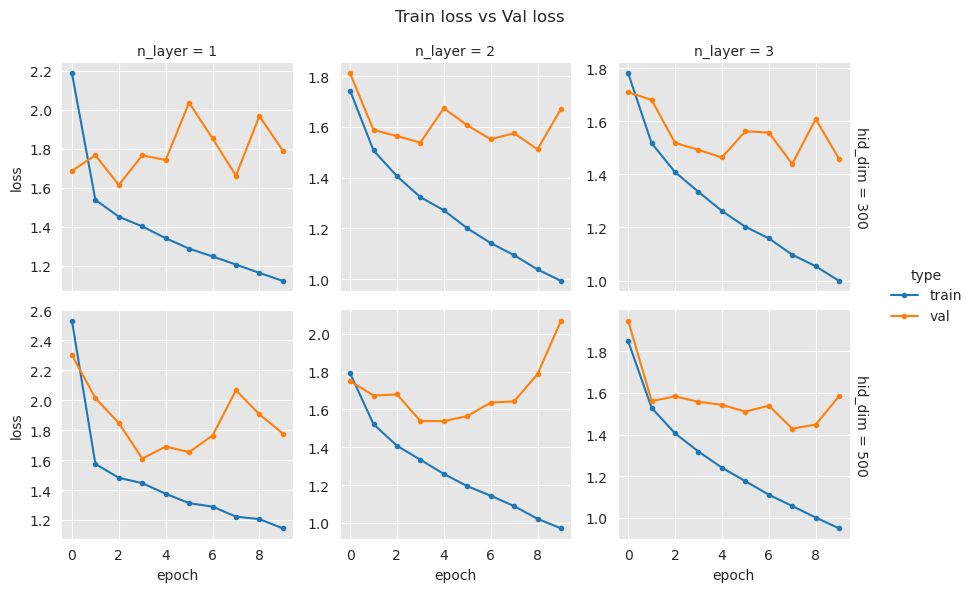

In [45]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique() # [2 3 1]
list_v2 = df[var2].unique() # [300 500]
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        #수많은 data record 중에서 해당 값들을 필터링 ( row 하나를 선택 )
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        #리스트를 끄집어내서 딕셔너리의 리스트로 만듦
        train_losses = list(row.train_losses)[0] #이중리스트라서 제거해줌
        val_losses = list(row.val_losses)[0]
        
        #딕셔너리의 리스트로 만듬
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)
#그림이 그려질 그리드를 만듬
#가로로는 layer수에 따라, 세로로는 hid_dim에 따라 subplot을 그릴거임, 계열은 train, val
#빈자리만 잡아둠
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
# g.map => plt.plot을 각각의 subplot에 대해 실행할 것이다. x => epoch, y=>loss
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

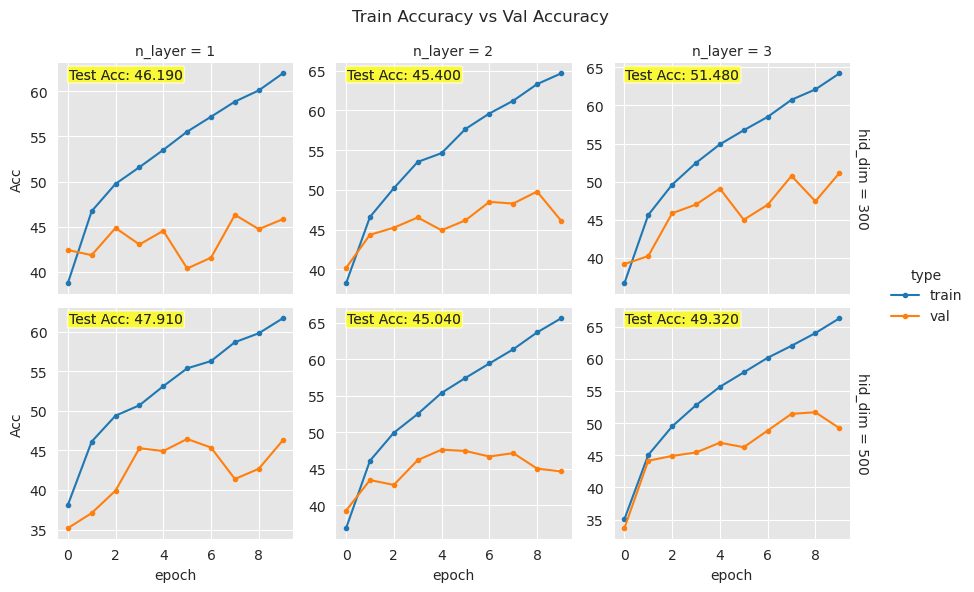

In [16]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')
plt.subplots_adjust(top=0.89)